# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

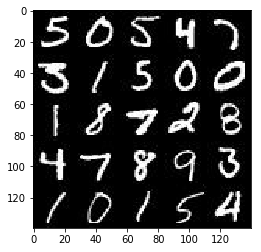

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

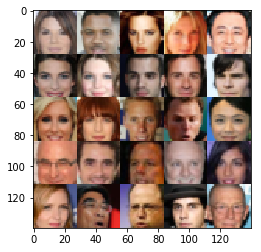

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    real_input = tf.placeholder(tf.float32, 
                                (None, image_width, image_height, image_channels), 
                                name = 'real_input') 
    
    z_input = tf.placeholder(tf.float32, (None, z_dim), name = 'z_input')
    
    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')

    return real_input, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [20]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # define alpha
        alpha = 0.2
        dev = 0.05
    
        # Input: 28, 28, 3
        x1 = tf.layers.conv2d(images, 
                              64, 
                              5, 
                              strides = 2, 
                              kernel_initializer = tf.random_normal_initializer(stddev=dev), 
                              padding = 'same')
        lrelu1 = tf.maximum(alpha * x1, x1)
        # Output: 14, 14, 64
    
        # Input: 14, 14, 64
        x2 = tf.layers.conv2d(lrelu1, 
                              128, 
                              5, 
                              strides = 2, 
                              kernel_initializer = tf.random_normal_initializer(stddev=dev), 
                              padding = 'same')
        
        bn2 = tf.layers.batch_normalization(x2, training = True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # Output: 7, 7, 128
    
        # Input: 7, 7, 128
        x3 = tf.layers.conv2d(lrelu2, 
                              256, 
                              5, 
                              strides = 2, 
                              kernel_initializer = tf.random_normal_initializer(stddev=dev), 
                              padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # Output: 4, 4, 256
    
        # Flatten
        flat = tf.reshape(lrelu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        alpha = 0.2
        dev = 0.05
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # 7,7,512
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 
                                        256, 
                                        5, 
                                        strides = 2, 
                                        kernel_initializer = tf.random_normal_initializer(stddev=dev), 
                                        padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # 14, 14, 256
    
        x3 = tf.layers.conv2d_transpose(lrelu2, 
                                        128, 
                                        5, 
                                        strides = 2, 
                                        kernel_initializer = tf.random_normal_initializer(stddev=dev), 
                                        padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        #28, 28, 128
    
        logits = tf.layers.conv2d_transpose(lrelu3, 
                                            out_channel_dim, 
                                            5, 
                                            strides = 1, 
                                            kernel_initializer = tf.random_normal_initializer(stddev=dev), 
                                            padding = 'same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth_factor = 0.9
    
    g_model = generator(input_z, out_channel_dim, True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                        labels = smooth_factor * tf.ones_like(d_model_real)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels = tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                                                   labels = tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    updt_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updt = [opt for opt in updt_ops if opt.name.startswith('discriminator')]
    g_updt = [opt for opt in updt_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(d_updt):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updt):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    
    return d_train_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    image_width = data_shape[1] 
    image_height = data_shape[2]
    image_channels = data_shape[3]
    n_images = 10
    
    real_input, z_input, learn_rate = model_inputs(image_width, 
                                                   image_height, 
                                                   image_channels, 
                                                   z_dim)
    
    d_loss, g_loss = model_loss(real_input, 
                                z_input, 
                                image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, 
                                         g_loss, 
                                         learning_rate, 
                                         beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                
                # Sample random noise for generator 
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {real_input : batch_images, 
                                                       z_input : batch_z,
                                                      learn_rate : learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {real_input : batch_images, 
                                                       z_input : batch_z,
                                                      learn_rate : learning_rate})
                
                if(steps % 100 == 0):
                    show_generator_output(sess, n_images, z_input, image_channels, data_image_mode)
                    
                if(steps % 10 == 0):    
                    train_loss_d = d_loss.eval({z_input : batch_z, 
                                                real_input : batch_images})
                    
                    train_loss_g = g_loss.eval({z_input : batch_z})
                    print("Epoch {}/{} ...".format(epoch_i + 1, epochs),
                         "Disc Loss: {:.4f} ... ".format(train_loss_d),
                         "Gen Loss: {:.4f}".format(train_loss_g))
                    
                    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ... Disc Loss: 1.4462 ...  Gen Loss: 0.6246
Epoch 1/2 ... Disc Loss: 2.0462 ...  Gen Loss: 0.3233
Epoch 1/2 ... Disc Loss: 1.5394 ...  Gen Loss: 0.4665
Epoch 1/2 ... Disc Loss: 1.4045 ...  Gen Loss: 0.6703
Epoch 1/2 ... Disc Loss: 1.0759 ...  Gen Loss: 0.9126
Epoch 1/2 ... Disc Loss: 1.4246 ...  Gen Loss: 0.5347
Epoch 1/2 ... Disc Loss: 1.0930 ...  Gen Loss: 1.0478
Epoch 1/2 ... Disc Loss: 1.2328 ...  Gen Loss: 1.5920
Epoch 1/2 ... Disc Loss: 1.1175 ...  Gen Loss: 1.1183


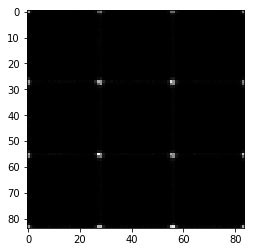

Epoch 1/2 ... Disc Loss: 1.1814 ...  Gen Loss: 0.7081
Epoch 1/2 ... Disc Loss: 0.8271 ...  Gen Loss: 1.7042
Epoch 1/2 ... Disc Loss: 1.0344 ...  Gen Loss: 1.7237
Epoch 1/2 ... Disc Loss: 0.5543 ...  Gen Loss: 2.1762
Epoch 1/2 ... Disc Loss: 1.1085 ...  Gen Loss: 0.7811
Epoch 1/2 ... Disc Loss: 0.9340 ...  Gen Loss: 1.5906
Epoch 1/2 ... Disc Loss: 0.9983 ...  Gen Loss: 0.8798
Epoch 1/2 ... Disc Loss: 0.7929 ...  Gen Loss: 1.8580
Epoch 1/2 ... Disc Loss: 0.8002 ...  Gen Loss: 3.2742
Epoch 1/2 ... Disc Loss: 1.0431 ...  Gen Loss: 1.2416


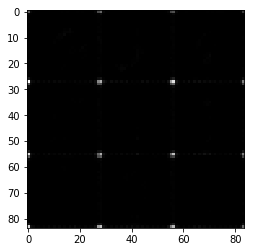

Epoch 1/2 ... Disc Loss: 1.4376 ...  Gen Loss: 0.5352
Epoch 1/2 ... Disc Loss: 0.8052 ...  Gen Loss: 1.2024
Epoch 1/2 ... Disc Loss: 1.3589 ...  Gen Loss: 2.1181
Epoch 1/2 ... Disc Loss: 1.1122 ...  Gen Loss: 0.7334
Epoch 1/2 ... Disc Loss: 0.8410 ...  Gen Loss: 1.6149
Epoch 1/2 ... Disc Loss: 1.2416 ...  Gen Loss: 2.4773
Epoch 1/2 ... Disc Loss: 1.2041 ...  Gen Loss: 0.6793
Epoch 1/2 ... Disc Loss: 1.0210 ...  Gen Loss: 0.8538
Epoch 1/2 ... Disc Loss: 1.0267 ...  Gen Loss: 0.9161
Epoch 1/2 ... Disc Loss: 0.7020 ...  Gen Loss: 1.6507


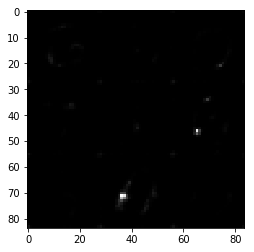

Epoch 1/2 ... Disc Loss: 1.2412 ...  Gen Loss: 0.6090
Epoch 1/2 ... Disc Loss: 0.9021 ...  Gen Loss: 1.0753
Epoch 1/2 ... Disc Loss: 1.2540 ...  Gen Loss: 0.6110
Epoch 1/2 ... Disc Loss: 0.8889 ...  Gen Loss: 1.3891
Epoch 1/2 ... Disc Loss: 0.8773 ...  Gen Loss: 1.2454
Epoch 1/2 ... Disc Loss: 1.1150 ...  Gen Loss: 0.7141
Epoch 1/2 ... Disc Loss: 0.9269 ...  Gen Loss: 1.2448
Epoch 1/2 ... Disc Loss: 1.3734 ...  Gen Loss: 0.5112
Epoch 1/2 ... Disc Loss: 1.0789 ...  Gen Loss: 1.1979
Epoch 1/2 ... Disc Loss: 1.0783 ...  Gen Loss: 0.8440


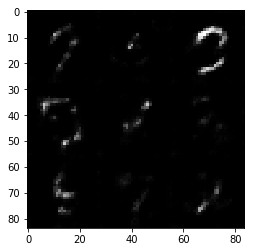

Epoch 1/2 ... Disc Loss: 0.6996 ...  Gen Loss: 1.5568
Epoch 1/2 ... Disc Loss: 0.8331 ...  Gen Loss: 1.4204
Epoch 1/2 ... Disc Loss: 1.1118 ...  Gen Loss: 0.7748
Epoch 1/2 ... Disc Loss: 1.1164 ...  Gen Loss: 2.3433
Epoch 1/2 ... Disc Loss: 1.2626 ...  Gen Loss: 0.6037
Epoch 1/2 ... Disc Loss: 1.6609 ...  Gen Loss: 2.7311
Epoch 1/2 ... Disc Loss: 1.5298 ...  Gen Loss: 0.4608
Epoch 1/2 ... Disc Loss: 0.8222 ...  Gen Loss: 1.3561
Epoch 1/2 ... Disc Loss: 0.8521 ...  Gen Loss: 1.5514
Epoch 1/2 ... Disc Loss: 0.9429 ...  Gen Loss: 1.0919


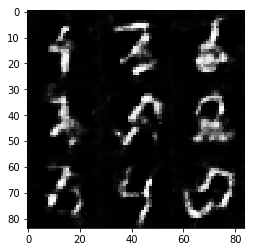

Epoch 1/2 ... Disc Loss: 1.3124 ...  Gen Loss: 0.5912
Epoch 1/2 ... Disc Loss: 1.2161 ...  Gen Loss: 0.6427
Epoch 1/2 ... Disc Loss: 1.1557 ...  Gen Loss: 0.6804
Epoch 1/2 ... Disc Loss: 1.0424 ...  Gen Loss: 0.8751
Epoch 1/2 ... Disc Loss: 1.3385 ...  Gen Loss: 0.5552
Epoch 1/2 ... Disc Loss: 0.8899 ...  Gen Loss: 1.0782
Epoch 1/2 ... Disc Loss: 0.9124 ...  Gen Loss: 1.2674
Epoch 1/2 ... Disc Loss: 0.8858 ...  Gen Loss: 1.2639
Epoch 1/2 ... Disc Loss: 1.1047 ...  Gen Loss: 0.9121
Epoch 1/2 ... Disc Loss: 1.1211 ...  Gen Loss: 0.9763


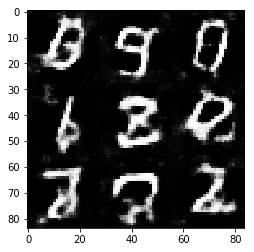

Epoch 1/2 ... Disc Loss: 1.1259 ...  Gen Loss: 0.8960
Epoch 1/2 ... Disc Loss: 1.0208 ...  Gen Loss: 1.7679
Epoch 1/2 ... Disc Loss: 1.0779 ...  Gen Loss: 1.3311
Epoch 1/2 ... Disc Loss: 1.0059 ...  Gen Loss: 0.9906
Epoch 1/2 ... Disc Loss: 1.0132 ...  Gen Loss: 1.0061
Epoch 1/2 ... Disc Loss: 0.9867 ...  Gen Loss: 1.0296
Epoch 1/2 ... Disc Loss: 1.3062 ...  Gen Loss: 0.5584
Epoch 1/2 ... Disc Loss: 1.1143 ...  Gen Loss: 0.9834
Epoch 1/2 ... Disc Loss: 1.0924 ...  Gen Loss: 1.3853
Epoch 1/2 ... Disc Loss: 1.3316 ...  Gen Loss: 1.7665


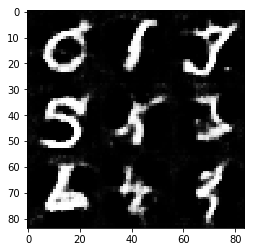

Epoch 1/2 ... Disc Loss: 0.9988 ...  Gen Loss: 1.1220
Epoch 1/2 ... Disc Loss: 1.3772 ...  Gen Loss: 0.4972
Epoch 1/2 ... Disc Loss: 1.0586 ...  Gen Loss: 1.0924
Epoch 1/2 ... Disc Loss: 1.0268 ...  Gen Loss: 1.2185
Epoch 1/2 ... Disc Loss: 1.4949 ...  Gen Loss: 0.4570
Epoch 1/2 ... Disc Loss: 1.0656 ...  Gen Loss: 1.4615
Epoch 1/2 ... Disc Loss: 1.0501 ...  Gen Loss: 1.6218
Epoch 1/2 ... Disc Loss: 1.2176 ...  Gen Loss: 0.6465
Epoch 1/2 ... Disc Loss: 1.5272 ...  Gen Loss: 0.4307
Epoch 1/2 ... Disc Loss: 1.0499 ...  Gen Loss: 1.1089


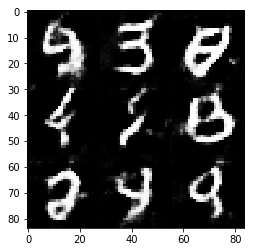

Epoch 1/2 ... Disc Loss: 1.1575 ...  Gen Loss: 0.7531
Epoch 1/2 ... Disc Loss: 0.8962 ...  Gen Loss: 1.7017
Epoch 1/2 ... Disc Loss: 1.0932 ...  Gen Loss: 0.8096
Epoch 1/2 ... Disc Loss: 1.2518 ...  Gen Loss: 0.6481
Epoch 1/2 ... Disc Loss: 1.0521 ...  Gen Loss: 0.9051
Epoch 1/2 ... Disc Loss: 0.9526 ...  Gen Loss: 0.9247
Epoch 1/2 ... Disc Loss: 1.2145 ...  Gen Loss: 0.7304
Epoch 1/2 ... Disc Loss: 0.8994 ...  Gen Loss: 1.0893
Epoch 1/2 ... Disc Loss: 1.6623 ...  Gen Loss: 0.3624
Epoch 1/2 ... Disc Loss: 0.9296 ...  Gen Loss: 1.7125


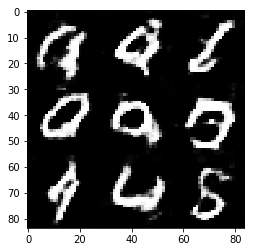

Epoch 1/2 ... Disc Loss: 0.9672 ...  Gen Loss: 0.9189
Epoch 1/2 ... Disc Loss: 0.9066 ...  Gen Loss: 1.2824
Epoch 1/2 ... Disc Loss: 1.5797 ...  Gen Loss: 0.3912
Epoch 1/2 ... Disc Loss: 1.0490 ...  Gen Loss: 1.3283
Epoch 2/2 ... Disc Loss: 1.1033 ...  Gen Loss: 3.6316
Epoch 2/2 ... Disc Loss: 1.1516 ...  Gen Loss: 0.7197
Epoch 2/2 ... Disc Loss: 1.0805 ...  Gen Loss: 0.8367
Epoch 2/2 ... Disc Loss: 1.1669 ...  Gen Loss: 0.7207
Epoch 2/2 ... Disc Loss: 0.9277 ...  Gen Loss: 1.0066
Epoch 2/2 ... Disc Loss: 0.8000 ...  Gen Loss: 1.1921


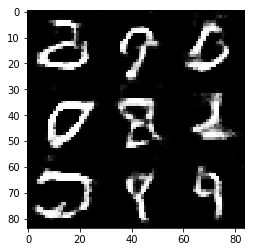

Epoch 2/2 ... Disc Loss: 1.2672 ...  Gen Loss: 0.6542
Epoch 2/2 ... Disc Loss: 0.9116 ...  Gen Loss: 1.1678
Epoch 2/2 ... Disc Loss: 1.5207 ...  Gen Loss: 0.4369
Epoch 2/2 ... Disc Loss: 1.0937 ...  Gen Loss: 0.8407
Epoch 2/2 ... Disc Loss: 1.2022 ...  Gen Loss: 0.6972
Epoch 2/2 ... Disc Loss: 0.9460 ...  Gen Loss: 0.9486
Epoch 2/2 ... Disc Loss: 1.3166 ...  Gen Loss: 0.5762
Epoch 2/2 ... Disc Loss: 1.1338 ...  Gen Loss: 0.7714
Epoch 2/2 ... Disc Loss: 0.9667 ...  Gen Loss: 1.9264
Epoch 2/2 ... Disc Loss: 1.1307 ...  Gen Loss: 0.7185


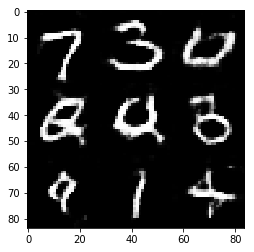

Epoch 2/2 ... Disc Loss: 1.1721 ...  Gen Loss: 0.7409
Epoch 2/2 ... Disc Loss: 1.1290 ...  Gen Loss: 0.7870
Epoch 2/2 ... Disc Loss: 0.8099 ...  Gen Loss: 1.1840
Epoch 2/2 ... Disc Loss: 1.6963 ...  Gen Loss: 0.4087
Epoch 2/2 ... Disc Loss: 0.8013 ...  Gen Loss: 1.8122
Epoch 2/2 ... Disc Loss: 1.3427 ...  Gen Loss: 0.5443
Epoch 2/2 ... Disc Loss: 0.9151 ...  Gen Loss: 1.0512
Epoch 2/2 ... Disc Loss: 1.5991 ...  Gen Loss: 0.4166
Epoch 2/2 ... Disc Loss: 1.1251 ...  Gen Loss: 1.6688
Epoch 2/2 ... Disc Loss: 0.9745 ...  Gen Loss: 1.1114


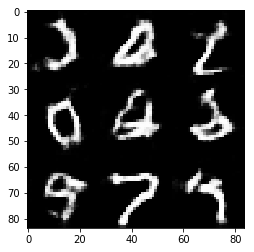

Epoch 2/2 ... Disc Loss: 0.8630 ...  Gen Loss: 1.2148
Epoch 2/2 ... Disc Loss: 0.9567 ...  Gen Loss: 1.0509
Epoch 2/2 ... Disc Loss: 1.0269 ...  Gen Loss: 0.8363
Epoch 2/2 ... Disc Loss: 1.1634 ...  Gen Loss: 0.7042
Epoch 2/2 ... Disc Loss: 0.8776 ...  Gen Loss: 1.2037
Epoch 2/2 ... Disc Loss: 1.1275 ...  Gen Loss: 2.9700
Epoch 2/2 ... Disc Loss: 0.9955 ...  Gen Loss: 0.9150
Epoch 2/2 ... Disc Loss: 1.3333 ...  Gen Loss: 0.5527
Epoch 2/2 ... Disc Loss: 1.1951 ...  Gen Loss: 0.6652
Epoch 2/2 ... Disc Loss: 1.0985 ...  Gen Loss: 0.9641


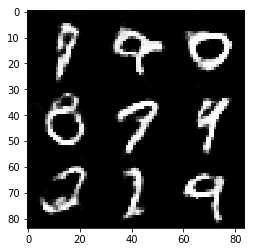

Epoch 2/2 ... Disc Loss: 0.9499 ...  Gen Loss: 1.1167
Epoch 2/2 ... Disc Loss: 0.9451 ...  Gen Loss: 0.9409
Epoch 2/2 ... Disc Loss: 0.9938 ...  Gen Loss: 1.5991
Epoch 2/2 ... Disc Loss: 0.9058 ...  Gen Loss: 1.4127
Epoch 2/2 ... Disc Loss: 1.3784 ...  Gen Loss: 0.5025
Epoch 2/2 ... Disc Loss: 0.8922 ...  Gen Loss: 1.5873
Epoch 2/2 ... Disc Loss: 0.9819 ...  Gen Loss: 1.1086
Epoch 2/2 ... Disc Loss: 1.0445 ...  Gen Loss: 0.8387
Epoch 2/2 ... Disc Loss: 0.9102 ...  Gen Loss: 1.0199
Epoch 2/2 ... Disc Loss: 0.8595 ...  Gen Loss: 1.4141


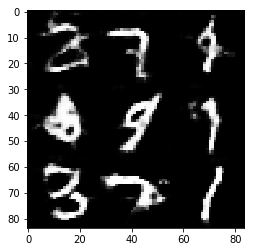

Epoch 2/2 ... Disc Loss: 1.0070 ...  Gen Loss: 0.9113
Epoch 2/2 ... Disc Loss: 0.9191 ...  Gen Loss: 1.6312
Epoch 2/2 ... Disc Loss: 1.1990 ...  Gen Loss: 0.7003
Epoch 2/2 ... Disc Loss: 1.1688 ...  Gen Loss: 0.6996
Epoch 2/2 ... Disc Loss: 1.0366 ...  Gen Loss: 1.0516
Epoch 2/2 ... Disc Loss: 1.0290 ...  Gen Loss: 0.9648
Epoch 2/2 ... Disc Loss: 1.2137 ...  Gen Loss: 0.6609
Epoch 2/2 ... Disc Loss: 2.2786 ...  Gen Loss: 3.2974
Epoch 2/2 ... Disc Loss: 0.9709 ...  Gen Loss: 1.1844
Epoch 2/2 ... Disc Loss: 1.0725 ...  Gen Loss: 0.8641


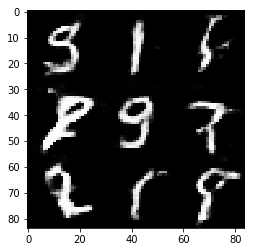

Epoch 2/2 ... Disc Loss: 1.2877 ...  Gen Loss: 0.5839
Epoch 2/2 ... Disc Loss: 0.9097 ...  Gen Loss: 1.1357
Epoch 2/2 ... Disc Loss: 1.4442 ...  Gen Loss: 0.4830
Epoch 2/2 ... Disc Loss: 1.1256 ...  Gen Loss: 0.6983
Epoch 2/2 ... Disc Loss: 1.1179 ...  Gen Loss: 0.7323
Epoch 2/2 ... Disc Loss: 1.4098 ...  Gen Loss: 0.5088
Epoch 2/2 ... Disc Loss: 0.9757 ...  Gen Loss: 1.0379
Epoch 2/2 ... Disc Loss: 1.1801 ...  Gen Loss: 0.7780
Epoch 2/2 ... Disc Loss: 0.8852 ...  Gen Loss: 1.0946
Epoch 2/2 ... Disc Loss: 0.9880 ...  Gen Loss: 2.6449


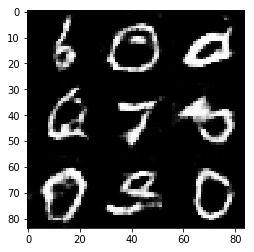

Epoch 2/2 ... Disc Loss: 1.0005 ...  Gen Loss: 1.0705
Epoch 2/2 ... Disc Loss: 0.9559 ...  Gen Loss: 0.9431
Epoch 2/2 ... Disc Loss: 0.9581 ...  Gen Loss: 0.9807
Epoch 2/2 ... Disc Loss: 0.9623 ...  Gen Loss: 0.9135
Epoch 2/2 ... Disc Loss: 0.8775 ...  Gen Loss: 1.9577
Epoch 2/2 ... Disc Loss: 0.9751 ...  Gen Loss: 1.1815
Epoch 2/2 ... Disc Loss: 0.9265 ...  Gen Loss: 1.1652
Epoch 2/2 ... Disc Loss: 0.9929 ...  Gen Loss: 1.2597
Epoch 2/2 ... Disc Loss: 0.9427 ...  Gen Loss: 1.2907
Epoch 2/2 ... Disc Loss: 1.5608 ...  Gen Loss: 0.4110


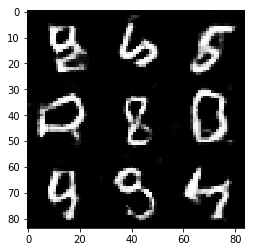

Epoch 2/2 ... Disc Loss: 0.7358 ...  Gen Loss: 1.6328
Epoch 2/2 ... Disc Loss: 1.0220 ...  Gen Loss: 0.8330
Epoch 2/2 ... Disc Loss: 0.7759 ...  Gen Loss: 1.2748
Epoch 2/2 ... Disc Loss: 1.8066 ...  Gen Loss: 0.4310
Epoch 2/2 ... Disc Loss: 0.8784 ...  Gen Loss: 1.3375
Epoch 2/2 ... Disc Loss: 0.9389 ...  Gen Loss: 1.4282
Epoch 2/2 ... Disc Loss: 0.9362 ...  Gen Loss: 1.5680
Epoch 2/2 ... Disc Loss: 0.9677 ...  Gen Loss: 0.9415
Epoch 2/2 ... Disc Loss: 1.3493 ...  Gen Loss: 0.5710
Epoch 2/2 ... Disc Loss: 0.8692 ...  Gen Loss: 1.1752


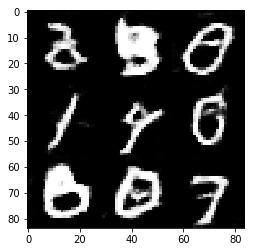

Epoch 2/2 ... Disc Loss: 1.2546 ...  Gen Loss: 2.9048
Epoch 2/2 ... Disc Loss: 1.1078 ...  Gen Loss: 0.7523
Epoch 2/2 ... Disc Loss: 0.9214 ...  Gen Loss: 1.1361
Epoch 2/2 ... Disc Loss: 0.9760 ...  Gen Loss: 1.3480
Epoch 2/2 ... Disc Loss: 0.9284 ...  Gen Loss: 1.6139
Epoch 2/2 ... Disc Loss: 1.0886 ...  Gen Loss: 0.7645
Epoch 2/2 ... Disc Loss: 0.9848 ...  Gen Loss: 0.8695
Epoch 2/2 ... Disc Loss: 0.9829 ...  Gen Loss: 1.0403


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ... Disc Loss: 2.7831 ...  Gen Loss: 0.1186
Epoch 1/1 ... Disc Loss: 2.6716 ...  Gen Loss: 0.1740
Epoch 1/1 ... Disc Loss: 2.1889 ...  Gen Loss: 0.2758
Epoch 1/1 ... Disc Loss: 1.6664 ...  Gen Loss: 0.4667
Epoch 1/1 ... Disc Loss: 1.4506 ...  Gen Loss: 0.5422
Epoch 1/1 ... Disc Loss: 1.3564 ...  Gen Loss: 0.6544
Epoch 1/1 ... Disc Loss: 1.0156 ...  Gen Loss: 0.9938
Epoch 1/1 ... Disc Loss: 0.9770 ...  Gen Loss: 0.9902
Epoch 1/1 ... Disc Loss: 0.8590 ...  Gen Loss: 1.2253


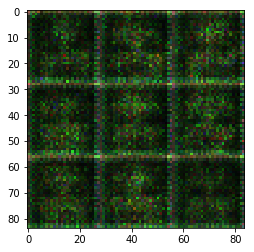

Epoch 1/1 ... Disc Loss: 0.8571 ...  Gen Loss: 1.1719
Epoch 1/1 ... Disc Loss: 0.8592 ...  Gen Loss: 1.2576
Epoch 1/1 ... Disc Loss: 0.7098 ...  Gen Loss: 1.7404
Epoch 1/1 ... Disc Loss: 0.7498 ...  Gen Loss: 1.5557
Epoch 1/1 ... Disc Loss: 0.8303 ...  Gen Loss: 1.4103
Epoch 1/1 ... Disc Loss: 0.7573 ...  Gen Loss: 1.4253
Epoch 1/1 ... Disc Loss: 0.7202 ...  Gen Loss: 1.4805
Epoch 1/1 ... Disc Loss: 0.7797 ...  Gen Loss: 1.4124
Epoch 1/1 ... Disc Loss: 0.6819 ...  Gen Loss: 1.6948
Epoch 1/1 ... Disc Loss: 0.6618 ...  Gen Loss: 1.6132


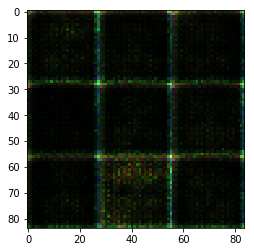

Epoch 1/1 ... Disc Loss: 0.9519 ...  Gen Loss: 1.0113
Epoch 1/1 ... Disc Loss: 0.5811 ...  Gen Loss: 1.9750
Epoch 1/1 ... Disc Loss: 0.6383 ...  Gen Loss: 1.9001
Epoch 1/1 ... Disc Loss: 0.5663 ...  Gen Loss: 2.2636
Epoch 1/1 ... Disc Loss: 0.8155 ...  Gen Loss: 1.1891
Epoch 1/1 ... Disc Loss: 0.4860 ...  Gen Loss: 2.8053
Epoch 1/1 ... Disc Loss: 0.8878 ...  Gen Loss: 0.9926
Epoch 1/1 ... Disc Loss: 1.6115 ...  Gen Loss: 0.3765
Epoch 1/1 ... Disc Loss: 0.4754 ...  Gen Loss: 2.7121
Epoch 1/1 ... Disc Loss: 0.5043 ...  Gen Loss: 2.4257


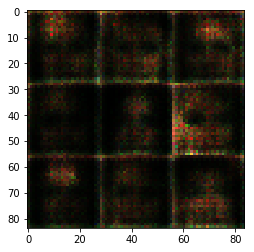

Epoch 1/1 ... Disc Loss: 0.5381 ...  Gen Loss: 2.5324
Epoch 1/1 ... Disc Loss: 0.5485 ...  Gen Loss: 3.4105
Epoch 1/1 ... Disc Loss: 0.7661 ...  Gen Loss: 3.9081
Epoch 1/1 ... Disc Loss: 0.4968 ...  Gen Loss: 2.5849
Epoch 1/1 ... Disc Loss: 0.4460 ...  Gen Loss: 4.0614
Epoch 1/1 ... Disc Loss: 0.8301 ...  Gen Loss: 1.1352
Epoch 1/1 ... Disc Loss: 0.7143 ...  Gen Loss: 1.4014
Epoch 1/1 ... Disc Loss: 0.4563 ...  Gen Loss: 4.6236
Epoch 1/1 ... Disc Loss: 0.4772 ...  Gen Loss: 3.4671
Epoch 1/1 ... Disc Loss: 0.4529 ...  Gen Loss: 3.9737


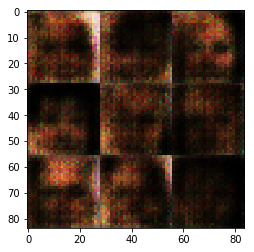

Epoch 1/1 ... Disc Loss: 0.4640 ...  Gen Loss: 3.5752
Epoch 1/1 ... Disc Loss: 0.4769 ...  Gen Loss: 2.5319
Epoch 1/1 ... Disc Loss: 1.0054 ...  Gen Loss: 3.7926
Epoch 1/1 ... Disc Loss: 0.7960 ...  Gen Loss: 3.7206
Epoch 1/1 ... Disc Loss: 0.4604 ...  Gen Loss: 2.8163
Epoch 1/1 ... Disc Loss: 0.8434 ...  Gen Loss: 5.3032
Epoch 1/1 ... Disc Loss: 0.8685 ...  Gen Loss: 1.7633
Epoch 1/1 ... Disc Loss: 0.7631 ...  Gen Loss: 4.3053
Epoch 1/1 ... Disc Loss: 0.7136 ...  Gen Loss: 1.4891
Epoch 1/1 ... Disc Loss: 0.5491 ...  Gen Loss: 4.0759


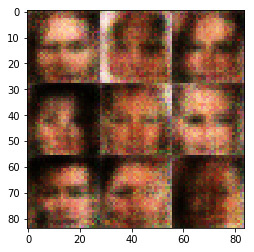

Epoch 1/1 ... Disc Loss: 0.9217 ...  Gen Loss: 1.0121
Epoch 1/1 ... Disc Loss: 1.2994 ...  Gen Loss: 0.5488
Epoch 1/1 ... Disc Loss: 1.3997 ...  Gen Loss: 0.5110
Epoch 1/1 ... Disc Loss: 0.4188 ...  Gen Loss: 6.7161
Epoch 1/1 ... Disc Loss: 0.5756 ...  Gen Loss: 3.0821
Epoch 1/1 ... Disc Loss: 0.5771 ...  Gen Loss: 1.7631
Epoch 1/1 ... Disc Loss: 0.7189 ...  Gen Loss: 1.7784
Epoch 1/1 ... Disc Loss: 0.7601 ...  Gen Loss: 4.4571
Epoch 1/1 ... Disc Loss: 0.7990 ...  Gen Loss: 1.2634
Epoch 1/1 ... Disc Loss: 0.3509 ...  Gen Loss: 6.0813


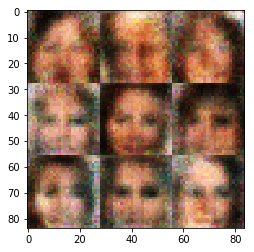

Epoch 1/1 ... Disc Loss: 1.1501 ...  Gen Loss: 0.6647
Epoch 1/1 ... Disc Loss: 0.5398 ...  Gen Loss: 1.9313
Epoch 1/1 ... Disc Loss: 0.4763 ...  Gen Loss: 2.3258
Epoch 1/1 ... Disc Loss: 1.5206 ...  Gen Loss: 0.4243
Epoch 1/1 ... Disc Loss: 1.1465 ...  Gen Loss: 0.6886
Epoch 1/1 ... Disc Loss: 0.3488 ...  Gen Loss: 8.5851
Epoch 1/1 ... Disc Loss: 0.4945 ...  Gen Loss: 5.7772
Epoch 1/1 ... Disc Loss: 0.4740 ...  Gen Loss: 6.2894
Epoch 1/1 ... Disc Loss: 0.6370 ...  Gen Loss: 1.5303
Epoch 1/1 ... Disc Loss: 0.5590 ...  Gen Loss: 1.8624


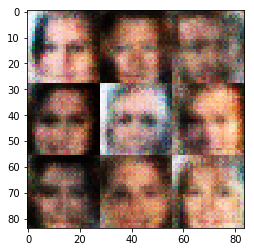

Epoch 1/1 ... Disc Loss: 0.3738 ...  Gen Loss: 6.0532
Epoch 1/1 ... Disc Loss: 1.3579 ...  Gen Loss: 0.5451
Epoch 1/1 ... Disc Loss: 0.8068 ...  Gen Loss: 3.9330
Epoch 1/1 ... Disc Loss: 0.3929 ...  Gen Loss: 6.2848
Epoch 1/1 ... Disc Loss: 0.4928 ...  Gen Loss: 8.0462
Epoch 1/1 ... Disc Loss: 0.5230 ...  Gen Loss: 1.9618
Epoch 1/1 ... Disc Loss: 0.4431 ...  Gen Loss: 3.7059
Epoch 1/1 ... Disc Loss: 0.3811 ...  Gen Loss: 4.0386
Epoch 1/1 ... Disc Loss: 0.8702 ...  Gen Loss: 0.9829
Epoch 1/1 ... Disc Loss: 0.5686 ...  Gen Loss: 7.5865


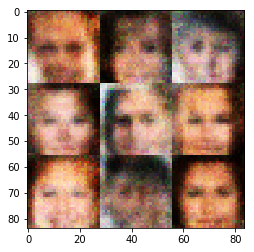

Epoch 1/1 ... Disc Loss: 0.3899 ...  Gen Loss: 3.3755
Epoch 1/1 ... Disc Loss: 0.5150 ...  Gen Loss: 3.0398
Epoch 1/1 ... Disc Loss: 0.7744 ...  Gen Loss: 1.1319
Epoch 1/1 ... Disc Loss: 0.6400 ...  Gen Loss: 9.7658
Epoch 1/1 ... Disc Loss: 1.1569 ...  Gen Loss: 1.3021
Epoch 1/1 ... Disc Loss: 2.6800 ...  Gen Loss: 0.1159
Epoch 1/1 ... Disc Loss: 0.9677 ...  Gen Loss: 1.6684
Epoch 1/1 ... Disc Loss: 0.4920 ...  Gen Loss: 3.2125
Epoch 1/1 ... Disc Loss: 0.7697 ...  Gen Loss: 1.7988
Epoch 1/1 ... Disc Loss: 0.4132 ...  Gen Loss: 9.8711


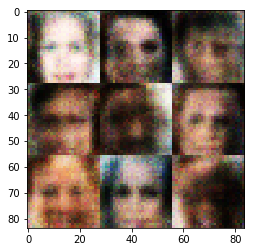

Epoch 1/1 ... Disc Loss: 0.4632 ...  Gen Loss: 7.2724
Epoch 1/1 ... Disc Loss: 1.2867 ...  Gen Loss: 0.5683
Epoch 1/1 ... Disc Loss: 0.4969 ...  Gen Loss: 2.1231
Epoch 1/1 ... Disc Loss: 1.6388 ...  Gen Loss: 0.3759
Epoch 1/1 ... Disc Loss: 0.6928 ...  Gen Loss: 3.9078
Epoch 1/1 ... Disc Loss: 0.5474 ...  Gen Loss: 2.0587
Epoch 1/1 ... Disc Loss: 0.5395 ...  Gen Loss: 1.9417
Epoch 1/1 ... Disc Loss: 0.5261 ...  Gen Loss: 3.4515
Epoch 1/1 ... Disc Loss: 1.2823 ...  Gen Loss: 0.5584
Epoch 1/1 ... Disc Loss: 0.5267 ...  Gen Loss: 2.1489


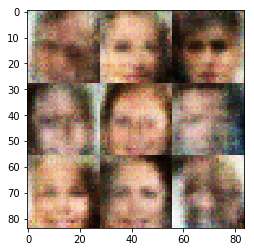

Epoch 1/1 ... Disc Loss: 0.3672 ...  Gen Loss: 6.6914
Epoch 1/1 ... Disc Loss: 1.5021 ...  Gen Loss: 0.4171
Epoch 1/1 ... Disc Loss: 0.7894 ...  Gen Loss: 1.5337
Epoch 1/1 ... Disc Loss: 0.5634 ...  Gen Loss: 9.9488
Epoch 1/1 ... Disc Loss: 0.4743 ...  Gen Loss: 2.3741
Epoch 1/1 ... Disc Loss: 0.4163 ...  Gen Loss: 5.5837
Epoch 1/1 ... Disc Loss: 0.7945 ...  Gen Loss: 1.7823
Epoch 1/1 ... Disc Loss: 0.3986 ...  Gen Loss: 3.4656
Epoch 1/1 ... Disc Loss: 0.4682 ...  Gen Loss: 2.6344
Epoch 1/1 ... Disc Loss: 0.4951 ...  Gen Loss: 2.6165


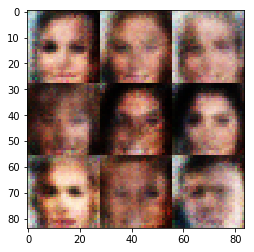

Epoch 1/1 ... Disc Loss: 1.3590 ...  Gen Loss: 0.6152
Epoch 1/1 ... Disc Loss: 0.4724 ...  Gen Loss: 7.3614
Epoch 1/1 ... Disc Loss: 0.6788 ...  Gen Loss: 3.2550
Epoch 1/1 ... Disc Loss: 0.5868 ...  Gen Loss: 2.0312
Epoch 1/1 ... Disc Loss: 0.8959 ...  Gen Loss: 1.6376
Epoch 1/1 ... Disc Loss: 0.6432 ...  Gen Loss: 1.4997
Epoch 1/1 ... Disc Loss: 1.3584 ...  Gen Loss: 1.6403
Epoch 1/1 ... Disc Loss: 0.5778 ...  Gen Loss: 2.1324
Epoch 1/1 ... Disc Loss: 0.7077 ...  Gen Loss: 3.9656
Epoch 1/1 ... Disc Loss: 0.9444 ...  Gen Loss: 0.8949


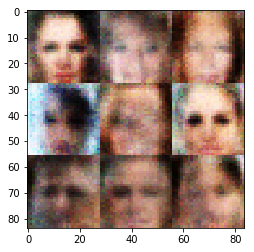

Epoch 1/1 ... Disc Loss: 2.0650 ...  Gen Loss: 0.2335
Epoch 1/1 ... Disc Loss: 0.7557 ...  Gen Loss: 1.5571
Epoch 1/1 ... Disc Loss: 0.7497 ...  Gen Loss: 1.7419
Epoch 1/1 ... Disc Loss: 0.7620 ...  Gen Loss: 5.2801
Epoch 1/1 ... Disc Loss: 0.4236 ...  Gen Loss: 2.7743
Epoch 1/1 ... Disc Loss: 0.6609 ...  Gen Loss: 3.2046
Epoch 1/1 ... Disc Loss: 1.7343 ...  Gen Loss: 4.4526
Epoch 1/1 ... Disc Loss: 0.7129 ...  Gen Loss: 8.4619
Epoch 1/1 ... Disc Loss: 1.2340 ...  Gen Loss: 1.6860
Epoch 1/1 ... Disc Loss: 0.6349 ...  Gen Loss: 5.5285


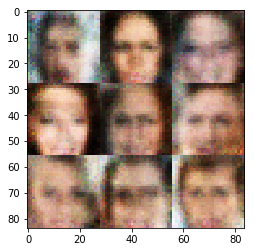

Epoch 1/1 ... Disc Loss: 1.2807 ...  Gen Loss: 1.8042
Epoch 1/1 ... Disc Loss: 0.5257 ...  Gen Loss: 2.1142
Epoch 1/1 ... Disc Loss: 0.3972 ...  Gen Loss: 7.8073
Epoch 1/1 ... Disc Loss: 0.8610 ...  Gen Loss: 2.7137
Epoch 1/1 ... Disc Loss: 1.0203 ...  Gen Loss: 1.4783
Epoch 1/1 ... Disc Loss: 1.4115 ...  Gen Loss: 0.4789
Epoch 1/1 ... Disc Loss: 0.6165 ...  Gen Loss: 1.5680
Epoch 1/1 ... Disc Loss: 0.4087 ...  Gen Loss: 3.3323
Epoch 1/1 ... Disc Loss: 0.6175 ...  Gen Loss: 1.7418
Epoch 1/1 ... Disc Loss: 0.7006 ...  Gen Loss: 5.8772


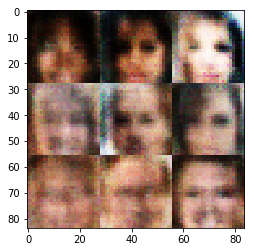

Epoch 1/1 ... Disc Loss: 0.4470 ...  Gen Loss: 6.7656
Epoch 1/1 ... Disc Loss: 0.4852 ...  Gen Loss: 2.2711
Epoch 1/1 ... Disc Loss: 0.6706 ...  Gen Loss: 1.3974
Epoch 1/1 ... Disc Loss: 0.3415 ...  Gen Loss: 8.7578
Epoch 1/1 ... Disc Loss: 1.1109 ...  Gen Loss: 0.7248
Epoch 1/1 ... Disc Loss: 0.4488 ...  Gen Loss: 6.7701
Epoch 1/1 ... Disc Loss: 0.4389 ...  Gen Loss: 5.0686
Epoch 1/1 ... Disc Loss: 0.3701 ...  Gen Loss: 4.4283
Epoch 1/1 ... Disc Loss: 0.3525 ...  Gen Loss: 5.0555
Epoch 1/1 ... Disc Loss: 0.4182 ...  Gen Loss: 3.9597


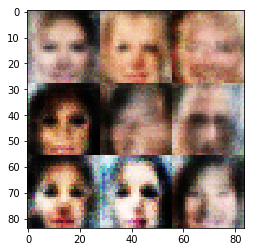

Epoch 1/1 ... Disc Loss: 0.3603 ...  Gen Loss: 3.9738
Epoch 1/1 ... Disc Loss: 0.6153 ...  Gen Loss: 7.0260
Epoch 1/1 ... Disc Loss: 0.8944 ...  Gen Loss: 0.9659
Epoch 1/1 ... Disc Loss: 0.4726 ...  Gen Loss: 7.4592
Epoch 1/1 ... Disc Loss: 0.4349 ...  Gen Loss: 5.4158
Epoch 1/1 ... Disc Loss: 0.6614 ...  Gen Loss: 3.7054
Epoch 1/1 ... Disc Loss: 0.3436 ...  Gen Loss: 8.9794
Epoch 1/1 ... Disc Loss: 0.5969 ...  Gen Loss: 2.8433
Epoch 1/1 ... Disc Loss: 0.4860 ...  Gen Loss: 2.1249
Epoch 1/1 ... Disc Loss: 1.7364 ...  Gen Loss: 0.3209


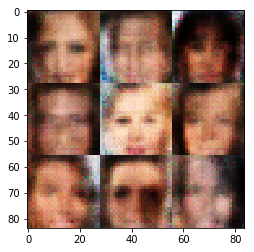

Epoch 1/1 ... Disc Loss: 0.3632 ...  Gen Loss: 5.1383
Epoch 1/1 ... Disc Loss: 0.8377 ...  Gen Loss: 2.7529
Epoch 1/1 ... Disc Loss: 0.3988 ...  Gen Loss: 7.9206
Epoch 1/1 ... Disc Loss: 0.3786 ...  Gen Loss: 4.0000
Epoch 1/1 ... Disc Loss: 0.4210 ...  Gen Loss: 3.0267
Epoch 1/1 ... Disc Loss: 0.4892 ...  Gen Loss: 2.4254
Epoch 1/1 ... Disc Loss: 0.3729 ...  Gen Loss: 4.6124
Epoch 1/1 ... Disc Loss: 0.8022 ...  Gen Loss: 1.8077
Epoch 1/1 ... Disc Loss: 0.3419 ...  Gen Loss: 8.4041
Epoch 1/1 ... Disc Loss: 0.5639 ...  Gen Loss: 6.8130


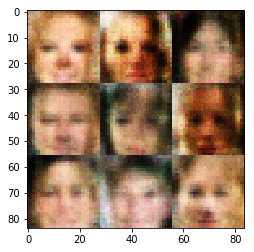

Epoch 1/1 ... Disc Loss: 0.4371 ...  Gen Loss: 6.2374
Epoch 1/1 ... Disc Loss: 0.4977 ...  Gen Loss: 3.3064
Epoch 1/1 ... Disc Loss: 0.4045 ...  Gen Loss: 3.6333
Epoch 1/1 ... Disc Loss: 0.4177 ...  Gen Loss: 6.0635
Epoch 1/1 ... Disc Loss: 0.7222 ...  Gen Loss: 1.2492
Epoch 1/1 ... Disc Loss: 1.7368 ...  Gen Loss: 0.3355
Epoch 1/1 ... Disc Loss: 0.3612 ...  Gen Loss: 4.2478
Epoch 1/1 ... Disc Loss: 0.6579 ...  Gen Loss: 5.7085
Epoch 1/1 ... Disc Loss: 0.3700 ...  Gen Loss: 4.6325
Epoch 1/1 ... Disc Loss: 0.4826 ...  Gen Loss: 3.5011


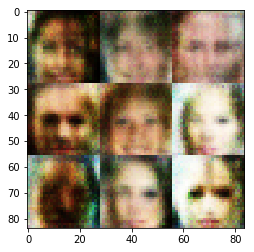

Epoch 1/1 ... Disc Loss: 0.3679 ...  Gen Loss: 8.0469
Epoch 1/1 ... Disc Loss: 0.3813 ...  Gen Loss: 4.2770
Epoch 1/1 ... Disc Loss: 0.4810 ...  Gen Loss: 6.4495
Epoch 1/1 ... Disc Loss: 0.5515 ...  Gen Loss: 6.1297
Epoch 1/1 ... Disc Loss: 0.5223 ...  Gen Loss: 6.4315
Epoch 1/1 ... Disc Loss: 0.5024 ...  Gen Loss: 2.6073
Epoch 1/1 ... Disc Loss: 0.4304 ...  Gen Loss: 6.6045
Epoch 1/1 ... Disc Loss: 1.0309 ...  Gen Loss: 0.8088
Epoch 1/1 ... Disc Loss: 0.4340 ...  Gen Loss: 3.9915
Epoch 1/1 ... Disc Loss: 0.5389 ...  Gen Loss: 1.9895


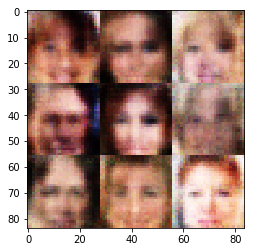

Epoch 1/1 ... Disc Loss: 1.0342 ...  Gen Loss: 0.7773
Epoch 1/1 ... Disc Loss: 0.7648 ...  Gen Loss: 1.2104
Epoch 1/1 ... Disc Loss: 0.7614 ...  Gen Loss: 2.1802
Epoch 1/1 ... Disc Loss: 0.3526 ...  Gen Loss: 6.9553
Epoch 1/1 ... Disc Loss: 0.6765 ...  Gen Loss: 1.6967
Epoch 1/1 ... Disc Loss: 0.3500 ...  Gen Loss: 5.3294
Epoch 1/1 ... Disc Loss: 0.3738 ...  Gen Loss: 3.9997
Epoch 1/1 ... Disc Loss: 0.3567 ...  Gen Loss: 5.0637
Epoch 1/1 ... Disc Loss: 1.1549 ...  Gen Loss: 2.1243
Epoch 1/1 ... Disc Loss: 1.3722 ...  Gen Loss: 0.5149


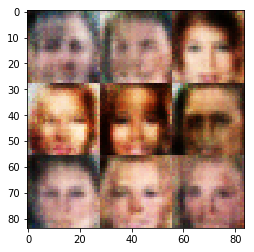

Epoch 1/1 ... Disc Loss: 0.4705 ...  Gen Loss: 3.5978
Epoch 1/1 ... Disc Loss: 0.3920 ...  Gen Loss: 3.5332
Epoch 1/1 ... Disc Loss: 0.3829 ...  Gen Loss: 4.1450
Epoch 1/1 ... Disc Loss: 0.5852 ...  Gen Loss: 1.8621
Epoch 1/1 ... Disc Loss: 0.5652 ...  Gen Loss: 1.7922
Epoch 1/1 ... Disc Loss: 1.7610 ...  Gen Loss: 0.3303
Epoch 1/1 ... Disc Loss: 0.4582 ...  Gen Loss: 2.4870
Epoch 1/1 ... Disc Loss: 0.4838 ...  Gen Loss: 4.4853
Epoch 1/1 ... Disc Loss: 0.4061 ...  Gen Loss: 3.2342
Epoch 1/1 ... Disc Loss: 0.4599 ...  Gen Loss: 6.3940


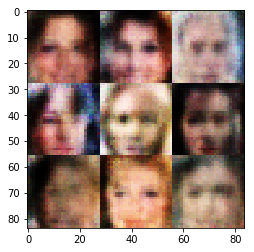

Epoch 1/1 ... Disc Loss: 0.3663 ...  Gen Loss: 3.8269
Epoch 1/1 ... Disc Loss: 0.5121 ...  Gen Loss: 3.1216
Epoch 1/1 ... Disc Loss: 0.9887 ...  Gen Loss: 0.8508
Epoch 1/1 ... Disc Loss: 0.4451 ...  Gen Loss: 2.4645
Epoch 1/1 ... Disc Loss: 0.4384 ...  Gen Loss: 4.9567
Epoch 1/1 ... Disc Loss: 0.3779 ...  Gen Loss: 5.8623
Epoch 1/1 ... Disc Loss: 0.5971 ...  Gen Loss: 2.0064
Epoch 1/1 ... Disc Loss: 0.3813 ...  Gen Loss: 6.6518
Epoch 1/1 ... Disc Loss: 0.5251 ...  Gen Loss: 2.0131
Epoch 1/1 ... Disc Loss: 0.3738 ...  Gen Loss: 6.0654


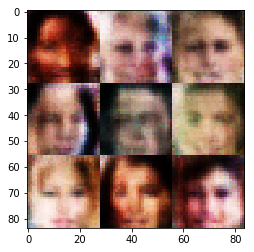

Epoch 1/1 ... Disc Loss: 0.9637 ...  Gen Loss: 2.8025
Epoch 1/1 ... Disc Loss: 0.7424 ...  Gen Loss: 1.3182
Epoch 1/1 ... Disc Loss: 0.3556 ...  Gen Loss: 5.3826
Epoch 1/1 ... Disc Loss: 0.7844 ...  Gen Loss: 2.3351
Epoch 1/1 ... Disc Loss: 0.7018 ...  Gen Loss: 11.3381
Epoch 1/1 ... Disc Loss: 0.3519 ...  Gen Loss: 6.2045
Epoch 1/1 ... Disc Loss: 0.6809 ...  Gen Loss: 1.3587
Epoch 1/1 ... Disc Loss: 1.0095 ...  Gen Loss: 5.7784
Epoch 1/1 ... Disc Loss: 0.3647 ...  Gen Loss: 5.0000
Epoch 1/1 ... Disc Loss: 0.8135 ...  Gen Loss: 2.1795


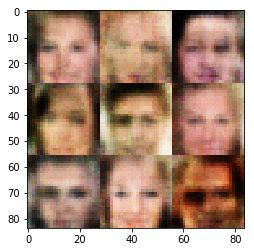

Epoch 1/1 ... Disc Loss: 0.9529 ...  Gen Loss: 8.2084
Epoch 1/1 ... Disc Loss: 0.3960 ...  Gen Loss: 3.7201
Epoch 1/1 ... Disc Loss: 0.4025 ...  Gen Loss: 7.6639
Epoch 1/1 ... Disc Loss: 0.5822 ...  Gen Loss: 1.7508
Epoch 1/1 ... Disc Loss: 1.3026 ...  Gen Loss: 0.5305
Epoch 1/1 ... Disc Loss: 0.3666 ...  Gen Loss: 6.5352
Epoch 1/1 ... Disc Loss: 1.0140 ...  Gen Loss: 0.8030
Epoch 1/1 ... Disc Loss: 0.6250 ...  Gen Loss: 4.5400
Epoch 1/1 ... Disc Loss: 0.5168 ...  Gen Loss: 2.0144
Epoch 1/1 ... Disc Loss: 0.6500 ...  Gen Loss: 2.3829


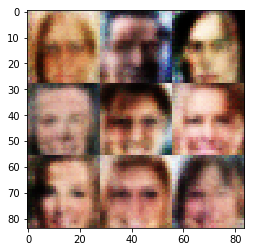

Epoch 1/1 ... Disc Loss: 0.8101 ...  Gen Loss: 4.6807
Epoch 1/1 ... Disc Loss: 0.3408 ...  Gen Loss: 6.5707
Epoch 1/1 ... Disc Loss: 0.4850 ...  Gen Loss: 3.8603
Epoch 1/1 ... Disc Loss: 0.6590 ...  Gen Loss: 4.2721
Epoch 1/1 ... Disc Loss: 0.3850 ...  Gen Loss: 4.3800
Epoch 1/1 ... Disc Loss: 0.6862 ...  Gen Loss: 7.3175
Epoch 1/1 ... Disc Loss: 0.5566 ...  Gen Loss: 9.0486
Epoch 1/1 ... Disc Loss: 0.4816 ...  Gen Loss: 2.2851
Epoch 1/1 ... Disc Loss: 0.3911 ...  Gen Loss: 6.1591
Epoch 1/1 ... Disc Loss: 1.8284 ...  Gen Loss: 0.2783


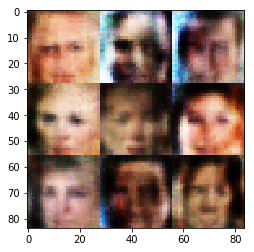

Epoch 1/1 ... Disc Loss: 0.9440 ...  Gen Loss: 0.8642
Epoch 1/1 ... Disc Loss: 0.3835 ...  Gen Loss: 4.4670
Epoch 1/1 ... Disc Loss: 0.6424 ...  Gen Loss: 1.5384
Epoch 1/1 ... Disc Loss: 0.3567 ...  Gen Loss: 4.4073
Epoch 1/1 ... Disc Loss: 0.5312 ...  Gen Loss: 1.9586
Epoch 1/1 ... Disc Loss: 0.3611 ...  Gen Loss: 4.0153
Epoch 1/1 ... Disc Loss: 0.3758 ...  Gen Loss: 5.3039
Epoch 1/1 ... Disc Loss: 0.3463 ...  Gen Loss: 5.7171
Epoch 1/1 ... Disc Loss: 0.4555 ...  Gen Loss: 8.9125
Epoch 1/1 ... Disc Loss: 0.3606 ...  Gen Loss: 4.2799


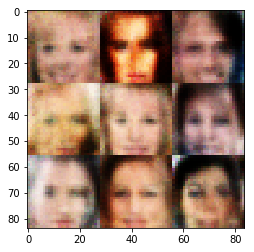

Epoch 1/1 ... Disc Loss: 0.3730 ...  Gen Loss: 3.6561
Epoch 1/1 ... Disc Loss: 0.4156 ...  Gen Loss: 10.6710
Epoch 1/1 ... Disc Loss: 0.7706 ...  Gen Loss: 1.2572
Epoch 1/1 ... Disc Loss: 0.3583 ...  Gen Loss: 5.0754
Epoch 1/1 ... Disc Loss: 0.3624 ...  Gen Loss: 4.6195
Epoch 1/1 ... Disc Loss: 0.3563 ...  Gen Loss: 5.1020
Epoch 1/1 ... Disc Loss: 0.3789 ...  Gen Loss: 3.5285
Epoch 1/1 ... Disc Loss: 2.0049 ...  Gen Loss: 0.2489
Epoch 1/1 ... Disc Loss: 1.0181 ...  Gen Loss: 0.7993
Epoch 1/1 ... Disc Loss: 0.4842 ...  Gen Loss: 11.8151


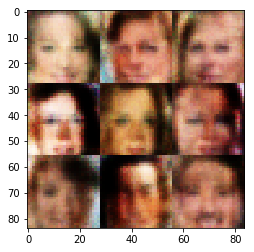

Epoch 1/1 ... Disc Loss: 0.3425 ...  Gen Loss: 7.7227
Epoch 1/1 ... Disc Loss: 0.3484 ...  Gen Loss: 6.4844
Epoch 1/1 ... Disc Loss: 0.3427 ...  Gen Loss: 8.4581
Epoch 1/1 ... Disc Loss: 0.5283 ...  Gen Loss: 2.8030
Epoch 1/1 ... Disc Loss: 0.3684 ...  Gen Loss: 7.9712
Epoch 1/1 ... Disc Loss: 0.3830 ...  Gen Loss: 3.4685
Epoch 1/1 ... Disc Loss: 0.3486 ...  Gen Loss: 6.4657
Epoch 1/1 ... Disc Loss: 0.9486 ...  Gen Loss: 0.8995
Epoch 1/1 ... Disc Loss: 0.3928 ...  Gen Loss: 5.4456
Epoch 1/1 ... Disc Loss: 0.3611 ...  Gen Loss: 4.2114


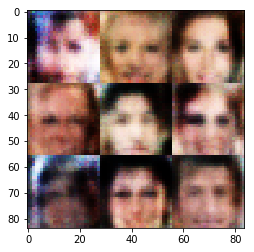

Epoch 1/1 ... Disc Loss: 0.3416 ...  Gen Loss: 5.9738
Epoch 1/1 ... Disc Loss: 0.3527 ...  Gen Loss: 7.0193
Epoch 1/1 ... Disc Loss: 0.5974 ...  Gen Loss: 1.7875
Epoch 1/1 ... Disc Loss: 0.3997 ...  Gen Loss: 2.9543
Epoch 1/1 ... Disc Loss: 0.4487 ...  Gen Loss: 2.6406
Epoch 1/1 ... Disc Loss: 0.4838 ...  Gen Loss: 6.4562
Epoch 1/1 ... Disc Loss: 0.4167 ...  Gen Loss: 4.2814
Epoch 1/1 ... Disc Loss: 1.1144 ...  Gen Loss: 0.7038
Epoch 1/1 ... Disc Loss: 0.8104 ...  Gen Loss: 5.0038
Epoch 1/1 ... Disc Loss: 0.3555 ...  Gen Loss: 4.9929


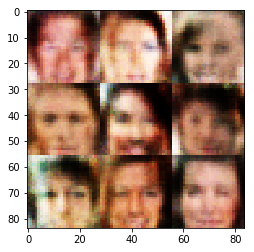

Epoch 1/1 ... Disc Loss: 1.4522 ...  Gen Loss: 0.5128
Epoch 1/1 ... Disc Loss: 0.4549 ...  Gen Loss: 2.5507
Epoch 1/1 ... Disc Loss: 0.3926 ...  Gen Loss: 10.0674
Epoch 1/1 ... Disc Loss: 0.3886 ...  Gen Loss: 5.9505
Epoch 1/1 ... Disc Loss: 0.3991 ...  Gen Loss: 3.5550
Epoch 1/1 ... Disc Loss: 0.4913 ...  Gen Loss: 2.1911
Epoch 1/1 ... Disc Loss: 0.3420 ...  Gen Loss: 6.5076
Epoch 1/1 ... Disc Loss: 0.3477 ...  Gen Loss: 7.9357
Epoch 1/1 ... Disc Loss: 0.3825 ...  Gen Loss: 5.8097
Epoch 1/1 ... Disc Loss: 1.2045 ...  Gen Loss: 7.1602


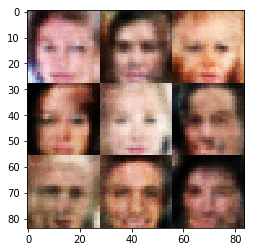

Epoch 1/1 ... Disc Loss: 0.3487 ...  Gen Loss: 4.7450
Epoch 1/1 ... Disc Loss: 0.3712 ...  Gen Loss: 3.6547
Epoch 1/1 ... Disc Loss: 0.5163 ...  Gen Loss: 5.4005
Epoch 1/1 ... Disc Loss: 0.4387 ...  Gen Loss: 9.6429
Epoch 1/1 ... Disc Loss: 0.5074 ...  Gen Loss: 8.6580
Epoch 1/1 ... Disc Loss: 0.4044 ...  Gen Loss: 3.0838
Epoch 1/1 ... Disc Loss: 1.2013 ...  Gen Loss: 0.6251
Epoch 1/1 ... Disc Loss: 0.3687 ...  Gen Loss: 5.3873
Epoch 1/1 ... Disc Loss: 1.3137 ...  Gen Loss: 0.5333
Epoch 1/1 ... Disc Loss: 0.3901 ...  Gen Loss: 6.7129


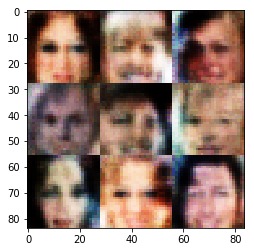

Epoch 1/1 ... Disc Loss: 0.4621 ...  Gen Loss: 3.3089
Epoch 1/1 ... Disc Loss: 0.3548 ...  Gen Loss: 4.6383
Epoch 1/1 ... Disc Loss: 0.3516 ...  Gen Loss: 5.5882
Epoch 1/1 ... Disc Loss: 0.3504 ...  Gen Loss: 5.4990
Epoch 1/1 ... Disc Loss: 0.4001 ...  Gen Loss: 7.7232
Epoch 1/1 ... Disc Loss: 0.4414 ...  Gen Loss: 2.5856
Epoch 1/1 ... Disc Loss: 0.3406 ...  Gen Loss: 6.7467


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.